# Bottom Up Attention with Detectron2
In this notebook, I'm looking to explore how to capture regional features from the Flickr30K dataset using Detectron2. For every image in the dataset, we extract the bounding boxes using a segmentation model, then compute the features in the bounded image.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install dependencies: 
# !pip install pyyaml==5.1
# !pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
from collections import defaultdict
#import exdir
import torch
import nltk
from copy import copy
from tqdm.notebook import tqdm
from torchvision.datasets import Flickr30k
from torchvision import models
import torchvision.transforms as transforms
import detectron2
import torch.nn as nn
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.structures.image_list import ImageList
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import string
from multiprocessing import Pool

save_regional_features = False
save_global_features = False

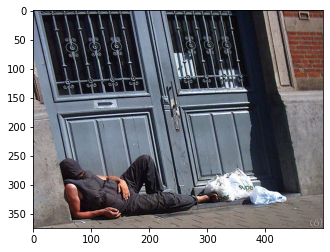

In [ ]:
image_path = "/content/drive/MyDrive/ECE763_Projects/data/flickr30k/flickr30k-images/353913.jpg"
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

RuntimeError: ignored

In [ ]:
outputs

{'instances': Instances(num_instances=1, image_height=375, image_width=500, fields=[pred_boxes: Boxes(tensor([[ 49.8907, 245.8973, 305.9599, 360.9300]], device='cuda:0')), scores: tensor([0.9799], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}

In [ ]:
height, width = im.shape[:2]
inputs = [{"image":im, "height": height, "width":width}]

In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0], device='cuda:0')
Boxes(tensor([[ 49.8907, 245.8973, 305.9599, 360.9300]], device='cuda:0'))


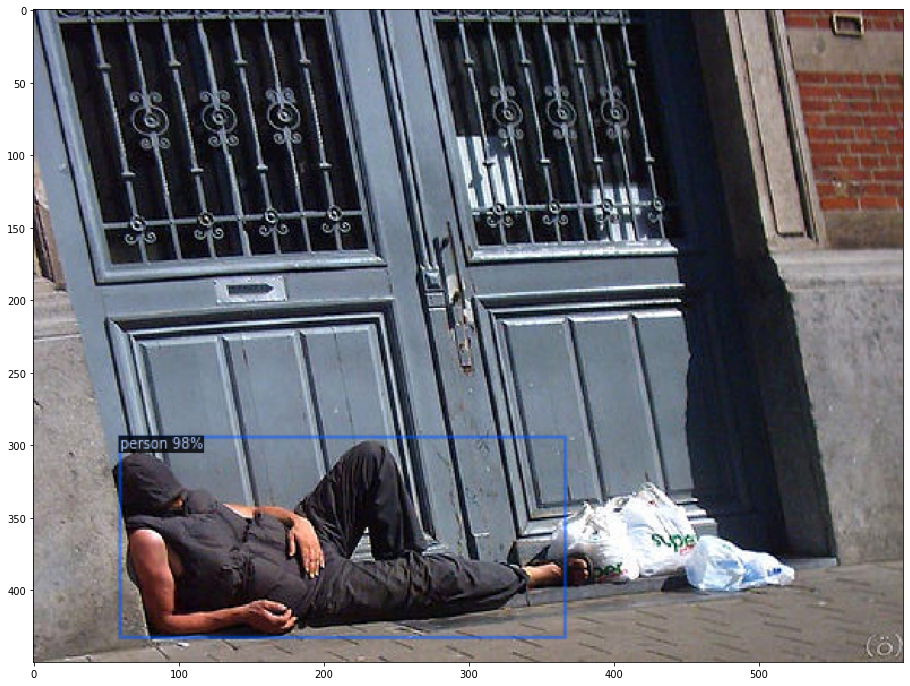

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,12))
plt.imshow(out.get_image()[:, :, ::-1])

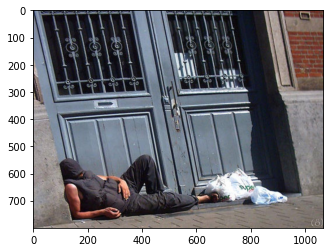

torch.Size([1, 3, 800, 1088])
torch.Size([1, 1024])


In [ ]:
height, width = im.shape[:2]
img = predictor.aug.get_transform(im).apply_image(im)
plt.imshow(img)
plt.show()
img = torch.as_tensor(img.astype("float32").transpose(2,0,1))
images = ImageList.from_tensors([img])
inputs = [{"image":img, "height": height, "width":width}]
with torch.no_grad():
    data = predictor.model.preprocess_image(inputs)
    print(data.tensor.size())
    features = predictor.model.backbone(data.tensor)
    proposals, _ = predictor.model.proposal_generator(data, features, None)

    proposal_boxes = [x.proposal_boxes for x in proposals]
    features_list = [features[f] for f in predictor.model.roi_heads.in_features]
    proposal_rois = predictor.model.roi_heads.box_pooler(features_list,  proposal_boxes)
    region_features = predictor.model.roi_heads.box_head(proposal_rois)  
    predictions = predictor.model.roi_heads.box_predictor(region_features)
    preds, pred_ind = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)
    preds = predictor.model.roi_heads.forward_with_given_boxes(features, preds)
    
    preds = predictor.model._postprocess(preds, inputs, images.image_sizes)
    feats = region_features[pred_ind]
print(feats.size())

In [ ]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [57.375, 57.12, 58.395], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BA

In [ ]:
#data is the image itself. size is torch.Size([1, 3, 800, 1088])
print(len(features["p2"][0][0][0]),len(features["p2"][0][0]),len(features["p2"][0]),len(features["p2"]))
print(len(features["p3"][0][0][0]),len(features["p3"][0][0]),len(features["p3"][0]),len(features["p3"]))
print(len(features["p4"][0][0][0]),len(features["p4"][0][0]),len(features["p4"][0]),len(features["p4"]))
print(len(features["p5"][0][0][0]),len(features["p5"][0][0]),len(features["p5"][0]),len(features["p5"]))
print(len(features["p6"][0][0][0]),len(features["p6"][0][0]),len(features["p6"][0]),len(features["p6"]))

272 200 256 1
136 100 256 1
68 50 256 1
34 25 256 1
17 13 256 1


In [ ]:
len(proposals[0]),proposals

(1000,
 [Instances(num_instances=1000, image_height=800, image_width=1067, fields=[proposal_boxes: Boxes(tensor([[ 83.2988, 367.8697, 680.6134, 777.5593],
          [  0.0000, 174.7548, 889.7754, 785.3413],
          [ 62.2155, 500.3502, 727.9796, 762.5714],
          ...,
          [176.7262, 102.1593, 224.9843, 237.0791],
          [525.7159, 354.6235, 542.7488, 400.1616],
          [116.5704, 243.0116, 135.2138, 262.0771]], device='cuda:0')), objectness_logits: tensor([ 9.1556,  7.5118,  7.4416,  7.3223,  6.8915,  6.6566,  6.0961,  5.5839,
           5.2919,  5.1351,  5.0788,  4.5712,  4.5216,  4.4988,  4.4216,  4.3549,
           4.2547,  4.1624,  4.1462,  4.0233,  3.7016,  3.5567,  3.4502,  3.1651,
           2.8854,  2.7676,  2.5580,  2.2356,  2.1182,  2.0864,  2.0075,  1.9554,
           1.9547,  1.8796,  1.8266,  1.7960,  1.7716,  1.4095,  1.1696,  1.1678,
           1.0945,  1.0026,  0.8721,  0.8568,  0.7646,  0.6132,  0.6101,  0.5258,
           0.5137,  0.5133,  0.4984,  0.4

In [ ]:
proposal_rois

tensor([[[[-1.2836e+00, -7.3903e-01,  1.9623e+00,  ..., -7.8805e-01,
           -6.9019e-01, -1.0156e+00],
          [-8.1840e-01, -1.6325e+00,  6.8981e-01,  ..., -7.3582e-01,
            4.0109e-01, -2.9355e-01],
          [-2.4715e-01, -4.5210e-03,  9.1850e-01,  ..., -1.5916e+00,
           -4.1136e-01,  4.9899e-01],
          ...,
          [-4.8463e-01, -5.9678e-01, -1.6164e+00,  ..., -1.3891e+00,
            2.3425e-01, -9.0183e-01],
          [-5.7887e-01,  1.1966e+00,  1.4439e+00,  ...,  8.1093e-01,
            1.8897e+00, -3.1247e-01],
          [ 1.0797e-01,  2.4543e+00,  3.3888e+00,  ...,  2.4810e+00,
            3.1519e+00,  1.7229e+00]],

         [[-8.3216e-02,  7.8835e-01,  2.9806e+00,  ...,  2.6455e+00,
            1.8246e+00,  2.1533e+00],
          [ 5.9861e-01,  1.2507e+00,  2.8800e+00,  ...,  2.0345e+00,
            1.5955e+00,  1.4762e+00],
          [ 3.7349e-01,  9.1330e-01,  2.3168e+00,  ...,  1.7586e+00,
            1.3635e+00,  7.8136e-01],
          ...,
     

In [ ]:
len(proposal_boxes[0])

1000

In [ ]:
data_img =np.load('/content/drive/MyDrive/ComputerVision/data_mount/flickr30k.exdir/train/1000092795.jpg/image/data.npy')
data_img, data_img.shape

(array([[[  0,   6,   4],
         [  2,   6,   5],
         [  3,   5,   4],
         ...,
         [219, 244, 249],
         [222, 253, 255],
         [221, 249, 250]],
 
        [[  4,   8,   7],
         [  3,   5,   4],
         [  5,   7,   6],
         ...,
         [228, 253, 250],
         [212, 245, 254],
         [218, 253, 255]],
 
        [[  3,   3,   3],
         [  4,   4,   4],
         [  5,   5,   5],
         ...,
         [242, 255, 255],
         [232, 255, 251],
         [214, 245, 250]],
 
        ...,
 
        [[166, 177, 147],
         [180, 188, 131],
         [130, 155, 100],
         ...,
         [106, 158,  86],
         [134, 172, 113],
         [107, 163,  72]],
 
        [[202, 219, 151],
         [144, 175, 115],
         [133, 160, 117],
         ...,
         [157, 188, 129],
         [156, 186, 124],
         [157, 196, 117]],
 
        [[144, 157,  87],
         [185, 211, 172],
         [184, 214, 152],
         ...,
         [156, 186, 122],
  

In [ ]:
data_reg_ft = np.load('/content/drive/MyDrive/ComputerVision/data_mount/flickr30k.exdir/train/1000092795.jpg/region_features/data.npy')
data_reg_ft,data_reg_ft.shape

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.14455906,
         0.01989658],
        [0.115035  , 0.14934437, 0.        , ..., 0.        , 0.1507053 ,
         0.23999411]], dtype=float32), (2, 1024))

In [ ]:
data_glb_ft = np.load('/content/drive/MyDrive/ComputerVision/data_mount/flickr30k.exdir/train/1000092795.jpg/global_features/data.npy')
data_glb_ft,data_glb_ft.shape

(array([0.29853478, 0.1615403 , 0.4930878 , ..., 0.02392756, 0.03349642,
        0.04176664], dtype=float32), (2048,))

In [ ]:
import yaml

attr = yaml.dump('/content/drive/MyDrive/ComputerVision/data_mount/flickr30k.exdir/train/1000092795.jpg/attributes.yaml') 
print(attr)

/content/drive/MyDrive/ComputerVision/data_mount/flickr30k.exdir/train/1000092795.jpg/attributes.yaml
...

